## Project Background
Autism Spectrum Disorder (ASD) affects communication and behavior. Early identification and intervention can significantly improve outcomes. This project aims to identify individuals who may be at higher risk for ASD based on commonly collected screening data (e.g., questionnaire responses, basic demographic information).

## Objective
The goal is to create a ML Ops tool that can do early detection for potential cases towards further clinical assessment, potentially speeding up the screening process and directing resources more effectively. This tool will predict the likelihood of an individual having Autism Spectrum Disorder (ASD) based on screening questionnaire data and demographic features, aiming for high sensitivity (recall) to minimize missed cases. This is a supervised binary classification problem (ASD vs. No ASD).

## Technical Background:
The model will use data from screenings to learn patterns in these features to distinguish between individuals diagnosed with ASD and those without.Technical challenges may involve preprocessing potentially imbalanced data, and ensuring fairness across different demographic groups by analyzing key metrics.
Evaluation will focus on classification performance metrics relevant to screening:
Primary Metrics: Recall (Sensitivity), AUC, PRC, Accuracy, Precision, F1-Score

Secondary Metrics: DIR, Relative Error, Force Plots. Correlation Plots.

Business/Clinical Relevance: Quantify the model's potential impact by simulating its use on a test set: calculate the percentage of true positive cases identified within the top X% of model predictions (e.g., top 20%), representing potential to accelerate workload for clinicians focusing on these high-risk individuals.


### Import libraries

In [2]:
!pip install awswrangler

  Using cached awswrangler-3.12.0-py3-none-any.whl.metadata (17 kB)
Using cached awswrangler-3.12.0-py3-none-any.whl (379 kB)


In [1]:
import numpy as np 
import pandas as pd 
import boto3
import sagemaker
from pyathena import connect
import matplotlib.pyplot as plt
import seaborn as sns
import awswrangler as wr

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
%pwd

'/home/sagemaker-user/aai_540_asd_detection'

### Load test and train dataset

In [3]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [4]:
test_df.dtypes

ID                   int64
A1_Score             int64
A2_Score             int64
A3_Score             int64
A4_Score             int64
A5_Score             int64
A6_Score             int64
A7_Score             int64
A8_Score             int64
A9_Score             int64
A10_Score            int64
age                float64
gender              object
ethnicity           object
jaundice            object
austim              object
contry_of_res       object
used_app_before     object
result             float64
age_desc            object
relation            object
dtype: object

In [5]:
train_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [6]:
test_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
0,1,1,1,0,0,1,1,0,0,1,...,15.599481,m,White-European,yes,no,India,no,12.399055,18 and more,Self
1,2,1,0,0,0,0,0,0,1,0,...,27.181099,m,Asian,no,no,Mexico,no,6.551598,18 and more,Self
2,3,1,1,1,0,1,1,0,1,1,...,31.643906,m,White-European,yes,no,Egypt,no,3.180663,18 and more,Self
3,4,0,0,0,0,0,0,0,0,0,...,25.369210,m,?,no,no,India,no,2.220766,18 and more,Self
4,5,0,0,0,1,0,0,0,0,0,...,9.078580,m,?,no,no,Italy,no,7.252028,18 and more,Self


### Create AWS session

In [11]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [10]:
### Create and Push Data to S3 bucket

In [12]:
s3_private_path_csv = "s3://{}/autism_prediction/csv".format(bucket)
print(s3_private_path_csv)

s3://sagemaker-us-west-2-204864359127/autism_prediction/csv


In [12]:
!aws s3 cp "./train.csv" $s3_private_path_csv/
!aws s3 cp "./test.csv" $s3_private_path_csv/

upload: ./train.csv to s3://sagemaker-us-west-2-204864359127/autism_prediction/csv/train.csv
upload: ./test.csv to s3://sagemaker-us-west-2-204864359127/autism_prediction/csv/test.csv


### Create ASW S3 Athena Database

In [13]:
database_name = "Autism_Predictions_Raw"
s3_staging_dir = "s3://sagemaker-us-west-2-204864359127/autism_prediction/csv/"
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS Autism_Predictions_Raw


/tmp/ipykernel_8866/3658760832.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [14]:
statement = "SHOW DATABASES LIKE 'autism_predictions_raw'"

df_show = pd.read_sql(statement, conn)
df_show.head(10)

/tmp/ipykernel_8866/1537493019.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,autism_predictions_raw


In [15]:
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [16]:
# Database name
database_name = "autism_predictions_raw"

# Create the Glue database if it doesn't exist
try:
    wr.catalog.create_database(name=database_name)
    print(f"Database '{database_name}' created successfully or already exists.")
except Exception as e:
    print(f"Error creating database: {e}")

Error creating database: Database autism_predictions_raw already exists and <exist_ok> is set to False.


In [18]:
# S3 bucket and file path for Parquet
bucket_name = "sagemaker-us-west-2-204864359127"
path = f"s3://{bucket_name}/autism_prediction/csv/" 

# Save DataFrame as Parquet to S3
try:
    wr.s3.to_parquet(
        df=train_df,
        path=path,
        dataset=True,
        mode="overwrite",
        database=database_name,
        table="asd_raw_prediction"
    )
    print(f"Data uploaded successfully to {path}.")
except Exception as e:
    print(f"Error uploading DataFrame to S3: {e}")

2025-06-13 04:30:56,122	WARNING services.py:2070 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 411017216 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.81gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-06-13 04:30:57,303	INFO worker.py:1852 -- Started a local Ray instance.


Data uploaded successfully to s3://sagemaker-us-west-2-204864359127/autism_prediction/csv/.


### Query the data from AWS Athena DB

In [19]:
# Query the table to check if the data is loaded
try:
    query = f"SELECT * FROM {database_name}.asd_raw_prediction LIMIT 5"
    df_sample = wr.athena.read_sql_query(query, database=database_name)
    print("Data from the ASD Athena table:")
    print(df_sample)
except Exception as e:
    print(f"Error querying table: {e}")

Data from the ASD Athena table:
   id  a1_score  a2_score  a3_score  a4_score  a5_score  a6_score  a7_score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   a8_score  a9_score  ...  gender       ethnicity jaundice austim  \
0         0         1  ...       f               ?       no     no   
1         0         0  ...       m               ?       no     no   
2         1         1  ...       m  White-European       no    yes   
3         0         0  ...       f               ?       no     no   
4         0         0  ...       m               ?       no     no   

   contry_of_res used_app_before     result     age_desc  relation class

In [30]:
df_sample.head(20)

,id,a1_score,a2_score,a3_score,a4_score,a5_score,a6_score,a7_score,a8_score,a9_score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,class_asd
0,1,1,0,1,0,1,0,1,0,1,...,38.172746,f,?,no,no,Austria,no,6.351166,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,47.750517,m,?,no,no,India,no,2.255185,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,7.380373,m,White-European,no,yes,United States,no,14.851484,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,23.561927,f,?,no,no,United States,no,2.276617,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,43.205790,m,?,no,no,South Africa,no,-4.777286,Self,0


### Plotting diagrams

In [4]:
train_df.describe

<bound method NDFrame.describe of       ID  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  \
0      1         1         0         1         0         1         0   
1      2         0         0         0         0         0         0   
2      3         1         1         1         1         1         1   
3      4         0         0         0         0         0         0   
4      5         0         0         0         0         0         0   
..   ...       ...       ...       ...       ...       ...       ...   
795  796         0         1         0         0         0         0   
796  797         0         1         1         0         0         1   
797  798         0         0         0         0         0         0   
798  799         0         0         0         0         0         0   
799  800         0         1         0         0         0         0   

     A7_Score  A8_Score  A9_Score  ...  gender       ethnicity jaundice  \
0           1         0   

In [5]:
test_df.describe

<bound method NDFrame.describe of       ID  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  \
0      1         1         1         0         0         1         1   
1      2         1         0         0         0         0         0   
2      3         1         1         1         0         1         1   
3      4         0         0         0         0         0         0   
4      5         0         0         0         1         0         0   
..   ...       ...       ...       ...       ...       ...       ...   
195  196         1         1         0         0         1         0   
196  197         1         0         0         0         0         0   
197  198         1         0         0         0         0         0   
198  199         0         1         0         0         0         0   
199  200         1         0         0         0         0         0   

     A7_Score  A8_Score  A9_Score  ...        age  gender       ethnicity  \
0           0         0 

In [7]:
train_df.dtypes

ID                   int64
A1_Score             int64
A2_Score             int64
A3_Score             int64
A4_Score             int64
A5_Score             int64
A6_Score             int64
A7_Score             int64
A8_Score             int64
A9_Score             int64
A10_Score            int64
age                float64
gender              object
ethnicity           object
jaundice            object
austim              object
contry_of_res       object
used_app_before     object
result             float64
age_desc            object
relation            object
Class/ASD            int64
dtype: object

In [8]:
test_df.dtypes

ID                   int64
A1_Score             int64
A2_Score             int64
A3_Score             int64
A4_Score             int64
A5_Score             int64
A6_Score             int64
A7_Score             int64
A8_Score             int64
A9_Score             int64
A10_Score            int64
age                float64
gender              object
ethnicity           object
jaundice            object
austim              object
contry_of_res       object
used_app_before     object
result             float64
age_desc            object
relation            object
dtype: object

<Axes: xlabel='Class/ASD', ylabel='age'>

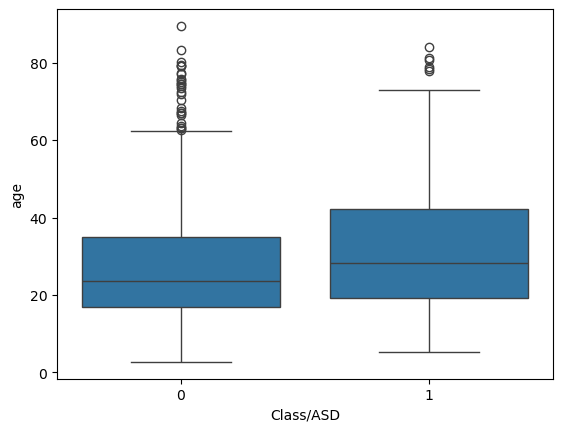

In [25]:
sns.boxplot(x = train_df['Class/ASD'], y = train_df['age'])

<Axes: xlabel='age', ylabel='Count'>

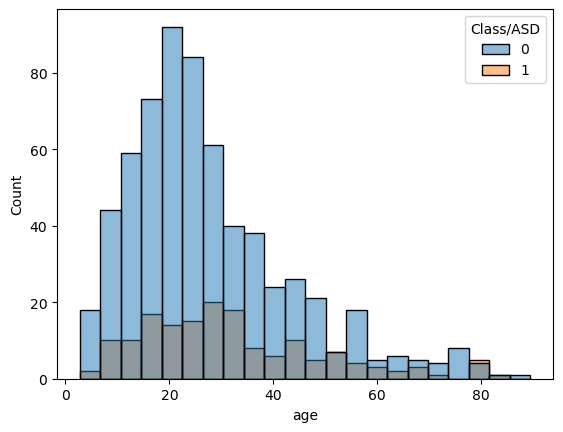

In [26]:
sns.histplot(x = train_df['age'], hue = train_df['Class/ASD'])

<Axes: xlabel='Class/ASD', ylabel='result'>

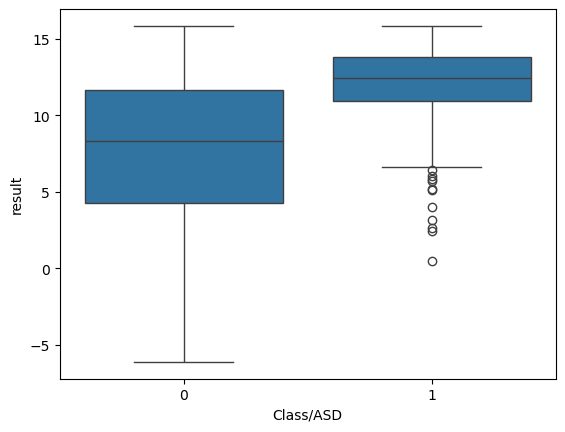

In [27]:
sns.boxplot(x = train_df['Class/ASD'], y = train_df['result'])

In [24]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['ID', 'relation', 'age_desc', 'Class/ASD'])
y = train_df['Class/ASD']

# Identify categorical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Encode categorical columns using OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_cols] = encoder.fit_transform(X[categorical_cols].astype(str))

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Accuracy: 0.85
Precision: 0.6875
Recall: 0.6111111111111112
F1 Score: 0.6470588235294118

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       124
           1       0.69      0.61      0.65        36

    accuracy                           0.85       160
   macro avg       0.79      0.77      0.78       160
weighted avg       0.84      0.85      0.85       160



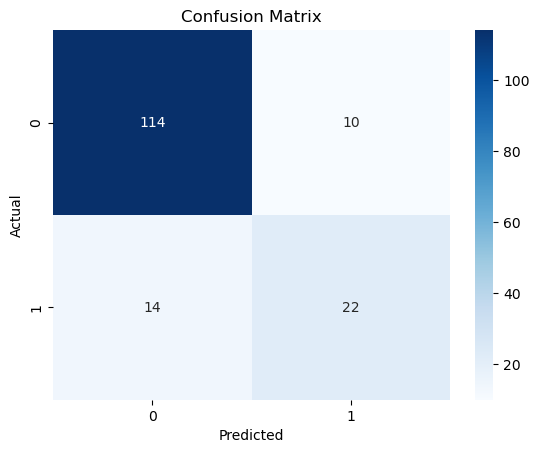

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [21]:
df_sample.describe

<bound method NDFrame.describe of    id  a1_score  a2_score  a3_score  a4_score  a5_score  a6_score  a7_score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   a8_score  a9_score  ...  gender       ethnicity jaundice austim  \
0         0         1  ...       f               ?       no     no   
1         0         0  ...       m               ?       no     no   
2         1         1  ...       m  White-European       no    yes   
3         0         0  ...       f               ?       no     no   
4         0         0  ...       m               ?       no     no   

   contry_of_res used_app_before     result     age_desc  relation cla

In [22]:
df_sample.drop(columns=['age_desc'], inplace=True)


In [23]:
df_sample.describe

<bound method NDFrame.describe of    id  a1_score  a2_score  a3_score  a4_score  a5_score  a6_score  a7_score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   a8_score  a9_score  ...        age  gender       ethnicity jaundice austim  \
0         0         1  ...  38.172746       f               ?       no     no   
1         0         0  ...  47.750517       m               ?       no     no   
2         1         1  ...   7.380373       m  White-European       no    yes   
3         0         0  ...  23.561927       f               ?       no     no   
4         0         0  ...  43.205790       m               ?       no     no   

   c

In [56]:
# Predict ASD probability for each individual
test_df['ASD_Probability'] = probs

# Simulate clinical triage: top 20% at risk
top_20 = test_df.sort_values(by='ASD_Probability', ascending=False).head(int(0.2 * len(test_df)))

# Display top entries
top_20[['ASD_Probability']].head()


,ASD_Probability
32,0.819988
47,0.812802
103,0.768830
16,0.764785
164,0.754219


# Release Resources

In [64]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

*** SIGTERM received at time=1749790842 on cpu 0 ***
PC: @     0x7f7e5799fe2e  (unknown)  epoll_wait
    @     0x7f7e04798b0d         64  absl::lts_20240722::AbslFailureSignalHandler()
    @     0x7f7e578bc520  (unknown)  (unknown)
[2025-06-13 05:00:42,176 E 8866 8866] logging.cc:497: *** SIGTERM received at time=1749790842 on cpu 0 ***
[2025-06-13 05:00:42,176 E 8866 8866] logging.cc:497: PC: @     0x7f7e5799fe2e  (unknown)  epoll_wait
[2025-06-13 05:00:42,178 E 8866 8866] logging.cc:497:     @     0x7f7e04798b39         64  absl::lts_20240722::AbslFailureSignalHandler()
[2025-06-13 05:00:42,178 E 8866 8866] logging.cc:497:     @     0x7f7e578bc520  (unknown)  (unknown)


In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

In [1]:
%pwd

'/home/sagemaker-user/aai_540_asd_detection'

In [7]:
!git branch

* JLong
  main


In [8]:
!git status

On branch JLong
Your branch is up to date with 'origin/JLong'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    AAI-540-Final-Project.ipynb
	deleted:    test.py
	deleted:    test2.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	AAI-540-Final-Project-Copy1.ipynb
	TestRun-Long.ipynb
	test.csv
	train.csv

no changes added to commit (use "git add" and/or "git commit -a")


In [9]:
!git add TestRun-Long.ipynb


In [10]:
!git commit -m "Add notebook TestRun-Long.ipynb"


[JLong fd85ec3] Add notebook TestRun-Long.ipynb
 1 file changed, 2661 insertions(+)
 create mode 100644 TestRun-Long.ipynb


In [ ]:
!git push origin JLong
